In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import time

In [2]:
def linear_kernel(x, y, b=1):
    
    return x @ y.T + b

In [3]:
def gaussian_kernel(x, y, sigma=1):
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- np.linalg.norm(x - y) / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- np.linalg.norm(x - y, axis=1) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], axis=2) / (2 * sigma ** 2))
    return result

In [4]:
class SMO_SVM:
    
    def __init__(self, C, kernel, alphas, b, errors):
        
        self.C = C               
        self.kernel = kernel     
        self.alphas = alphas     
        self.b = b               
        self.errors = errors
      
    
    def objective_fun(self):
    
        return np.sum(self.alphas) - 0.5 * np.sum(self.y_train * self.y_train * self.kernel(self.X_train, self.X_train) * self.alphas * self.alphas)

    def decision_fun(self, X_train, y_train):
        
        result = (self.alphas * y_train) @ self.kernel(X_train, X_train) - self.b
        return result
    
    def predict(self, X_test):

        result = (self.alphas * self.y_train) @ self.kernel(self.X_train, X_test) - self.b
        return result
    
    
    def plot_decision_boundary(self, _plt, num=50):
        
        x1_range = np.linspace(self.X_train[:,0].min(), self.X_train[:,0].max(), num)
        x2_range = np.linspace(self.X_train[:,1].min(), self.X_train[:,1].max(), num)
        grid = [[self.predict(np.array([x1, x2])) for x2 in x2_range] for x1 in x1_range]
        grid = np.array(grid).reshape(len(x1_range), len(x2_range))
        
        _plt.contour(x1_range, x2_range, grid, (-1, 0, 1))
        _plt.scatter(self.X_train[:,0], self.X_train[:,1], c=self.y_train)
        
#         mask = self.alphas != 0.0
#         _plt.scatter(self.X_train[:,0][mask], self.X_train[:,1][mask], c=self.y_train[mask], cmap=plt.cm.viridis)
        
#         return grid, _plt
    
    def take_step(self, i1, i2):
    
        # if both lagragnge multipliers are same then return 
        if i1 == i2:
            return 0

        alpha1 = self.alphas[i1]
        alpha2 = self.alphas[i2]
        y1 = self.y_train[i1]
        y2 = self.y_train[i2]
        E1 = self.errors[i1]
        E2 = self.errors[i2]
        s = y1 * y2


        if (y1 != y2):
            L = max(0, alpha2 - alpha1)
            H = min(self.C, self.C + alpha2 - alpha1)
        else:
            L = max(0, alpha1 + alpha2 - self.C)
            H = min(self.C, alpha1 + alpha2)
          
        # if constraint is just a point then return 
        if (L == H):
            return 0

        k11 = self.kernel(self.X_train[i1], self.X_train[i1])
        k12 = self.kernel(self.X_train[i1], self.X_train[i2])
        k22 = self.kernel(self.X_train[i2], self.X_train[i2])
        eta = 2 * k12 - k11 - k22

        if (eta < 0):
            alpha2_new = alpha2 - y2 * (E1 - E2) / eta  #derived analytically
            if (alpha2_new <= L):
                alpha2_new = L
            elif (alpha2_new >= H):
                alpha2_new = H
        else:
            alphas_copy = self.alphas.copy()
            alphas_copy[i2] = L
            Lobj = self.objective_fun() 
            alphas_copy[i2] = H
            Hobj = self.objective_fun()
            if Lobj > (Hobj + eps):
                alpha2_new = L
            elif Hobj > (Lobj + eps):
                alpha2_new = H
            else:
                alpha2_new = alpha2

        # check for end limits
        if alpha2_new < 1e-9:
            a2 = 0.0
        elif alpha2_new > (self.C - 1e-9):
            a2 = self.C

        if (np.abs(alpha2_new - alpha2) < eps * (alpha2_new + alpha2 + eps)):
            return 0

        alpha1_new = alpha1 + s * (alpha2 - alpha2_new) #derived anal

        # bias update(formula derived and then implemented)
        b1 = E1 + y1 * (alpha1_new - alpha1) * k11 + y2 * (alpha2_new - alpha2) * k12 + self.b
        b2 = E2 + y1 * (alpha1_new - alpha1) * k12 + y2 * (alpha2_new - alpha2) * k22 + self.b

        #choose bias update according to new alphas
        if 0 < alpha1_new < C:
            b_new = b1
        elif 0 < alpha2_new < C:
            b_new = b2
        else:
            b_new = 0.5 * (b1 + b2)

        self.alphas[i1] = alpha1_new
        self.alphas[i2] = alpha2_new

        for index, alpha in zip([i1, i2], [alpha1_new, alpha2_new]):
            if 0.0 < alpha < self.C:
                self.errors[index] = 0.0
        #update errors
        non_opt = [n for n in range(self.m) if (n != i1 and n != i2)]
        self.errors[non_opt] += y1*(alpha1_new - alpha1)*self.kernel(self.X_train[i1], self.X_train[non_opt]) + \
                                y2*(alpha2_new - alpha2)*self.kernel(self.X_train[i2], self.X_train[non_opt]) + self.b - b_new

        self.b = b_new

        return 1
    
    
    def examine_example(self, i2):

        y2 = self.y_train[i2]
        alpha2 = self.alphas[i2]
        E2 = self.errors[i2]
        r2 = E2 * y2

        if ((r2 < -tol and alpha2 < self.C) or (r2 > tol and alpha2 > 0)):
            if len(self.alphas[(self.alphas != 0) & (self.alphas != self.C)]) > 1:
                # find other lagrangian index such that difference between errors are maximum
                if self.errors[i2] > 0:
                    i1 = np.argmin(self.errors)
                elif self.errors[i2] <= 0:
                    i1 = np.argmax(self.errors)
                if self.take_step(i1, i2):
                    return 1
            # if cant find lagrangian in above then iterate through non-bound examples
            for i1 in np.roll(np.where((self.alphas != 0) & (self.alphas != self.C))[0],
                              np.random.choice(np.arange(self.m))):
                if self.take_step(i1, i2):
                    return 1
            # if cant find lagrangian in above then search whole example
            for i1 in np.roll(np.arange(self.m), np.random.choice(np.arange(self.m))):
                if self.take_step(i1, i2):
                    return 1

        return 0
    
    
    def fit(self, X_train , y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.m = len(self.X_train)
    
        
        findAll = 1
        count = 0
        # Converges if in the current search no multiplier were found
        while(count > 0) or (findAll):
            count = 0
            if findAll:
                for i in range(self.alphas.shape[0]):
                    count += self.examine_example(i)        
            else:
                for i in np.where((self.alphas != 0) & (self.alphas != self.C))[0]:
                    count +=  self.examine_example(i)
                    
            # examine all exmaples alternately (itr1: All, itr2:Not All etc)
            if findAll == 1:
                findAll = 0
            elif count == 0: # we need to examine all examples if no change is found in current iteration
                findAll = 1


In [5]:
# Linearly seperable Data
n_samples = 3000
X, y = make_blobs(n_samples=n_samples, centers=2, n_features=2, random_state=1)
scaler = StandardScaler()
X = scaler.fit_transform(X, y)
y[y == 0] = -1

X_train = X[0:int(0.9*n_samples),:]
y_train = y[0:int(0.9*n_samples)]

X_test = X[int(0.9*n_samples):,:]
y_test = y[int(0.9*n_samples):]
X_train.shape,X_test.shape, y_train.shape, y_test.shape

((2700, 2), (300, 2), (2700,), (300,))

In [6]:
# Hyperparameters
C = 1
m = len(X_train)
initial_alphas = np.zeros(m)
initial_b = 0.0

tol = 0.01 
eps = 0.01 

In [7]:
# Buiding Model
model = SMO_SVM(C, linear_kernel, initial_alphas, initial_b, np.zeros(m))
initial_error = model.decision_fun(X_train, y_train) - y_train
model.errors = initial_error
np.random.seed(0)

In [8]:
# Train the model
start = time.clock()
model.fit(X_train, y_train)
print(time.clock() - start)

0.13043199999999988


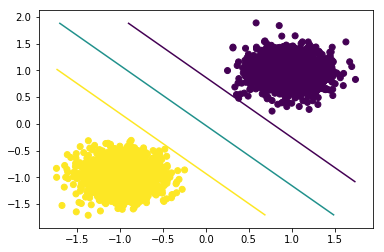

In [9]:
# plotting the model
fig, _plt = plt.subplots()
model.plot_decision_boundary(_plt)

In [10]:
# Test the model
y_predict = model.predict(X_test)
correct = np.sum(np.sign(y_predict) == y_test)
print("%d out of %d predictions correct" % (correct, len(y_predict)))

300 out of 300 predictions correct
